##### Copyright 2019 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#How to train Boosted Trees models in TensorFlow

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/estimators/boosted_trees"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/estimators/boosted_trees.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/tree/master/site/en/tutorials/estimators/boosted_trees.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">View source on GitHub</a>
  </td>
</table>

Note: これらのドキュメントは私たちTensorFlowコミュニティが翻訳したものです。コミュニティによる 翻訳は**ベストエフォート**であるため、この翻訳が正確であることや[英語の公式ドキュメント](https://www.tensorflow.org/?hl=en)の 最新の状態を反映したものであることを保証することはできません。 この翻訳の品質を向上させるためのご意見をお持ちの方は、GitHubリポジトリ[tensorflow/docs](https://github.com/tensorflow/docs)にプルリクエストをお送りください。 コミュニティによる翻訳やレビューに参加していただける方は、 [docs-ja@tensorflow.org メーリングリスト](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-ja)にご連絡ください。

このチュートリアルでは、決定木 (decision tree) を用いた勾配ブースティング (Gradient Boosting) モデルの`tf.estimator` APIによる学習について、最初から最後まで一通りの手順を行います。勾配ブースティング木は回帰問題にも分類問題にも適用できる機械学習の手法であり、非情に性能が高く、また広く知られているものです。この手法はアンサンブル学習と呼ばれるテクニックの一つで、それぞれの(数十、数百、数千の)決定木モデルを組み合わせて使う方法です。

勾配ブースティング木は機械学習を実践する人にとって広く用いられるもので、ハイパーパラメータチューニングが小規模であるにもかかわらず、目覚ましい成果が挙げられています。

## タイタニックデータセットの読み込み

ここではタイタニック号のデータセットを用いて、乗客の性別、年齢、チケットの等級といった情報から、その乗客が生き延びたかどうかの予測を行います。

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()

tf.logging.set_verbosity(tf.logging.ERROR)
tf.set_random_seed(123)

# データセットの読み込み
dftrain = pd.read_csv('https://storage.googleapis.com/tfbt/titanic_train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tfbt/titanic_eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

このデータセットでは学習データと評価データの両方のデータが含まれています。内訳は次のとおりです。


* `dftrain` と `y_train` は *学習データ*です —これらを用いてモデルを学習させます。
* `dfeval`と`y_eval`は*評価データ*です —これらのデータは学習済みモデルの評価に使います。

モデルの学習に利用する特徴量は次のとおりです。

<table>
  <tr>
    <th>特徴量</th>
    <th>詳細</th>
  </tr>
  <tr>
    <td>sex</td>
    <td>乗客の性別</td>
  </tr>
  <tr>
    <td>age</td>
    <td>乗客の年齢</td>
  </tr>
    <tr>
    <td>n_siblings_spouses</td>
    <td>同乗する配偶者や兄弟/姉妹の数</td>
  </tr>
    <tr>
    <td>parch</td>
    <td>同乗する両親や子供の数</td>
  </tr>
    <tr>
    <td>fare</td>
    <td>料金</td>
  </tr>
    <tr>
    <td>class</td>
    <td>等級</td>
  </tr>
    <tr>
    <td>deck</td>
    <td>デッキ(船内の各階層)</td>
  </tr>
    <tr>
    <td>embark_town</td>
    <td>乗船した港</td>
  </tr>
    <tr>
    <td>alone</td>
    <td>乗客が一人だけかどうか</td>
  </tr>
</table>

## データの探索

まず学習データから最初のいくつかのデータを確認し、次に学習データの基本統計量を作成しましょう。


In [4]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [5]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


学習データには627個、評価データには264個のデータが含まれているはずです。


In [6]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

乗客の多数は、年齢が20代から30代です。


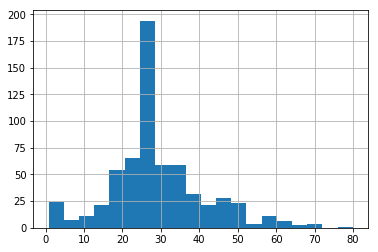

In [7]:
dftrain.age.hist(bins=20)
plt.show()

乗客のうち男性は、女性の概ね二倍程度乗船していました。


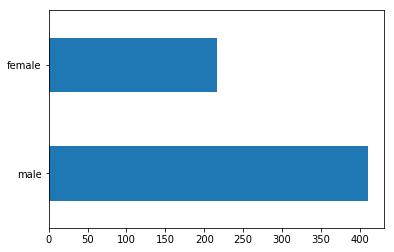

In [10]:
dftrain.sex.value_counts().plot(kind='barh')
plt.show()

乗客の客室の区分では、3等級が最も多かったです。

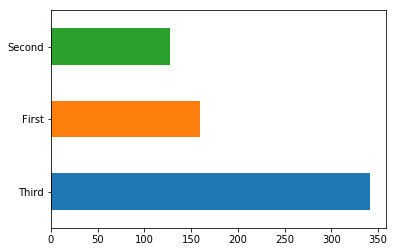

In [0]:
(dftrain['class']
  .value_counts()
  .plot(kind='barh'))
plt.show()

大半の乗客はサウサンプトン(Southampton)から乗船しました。


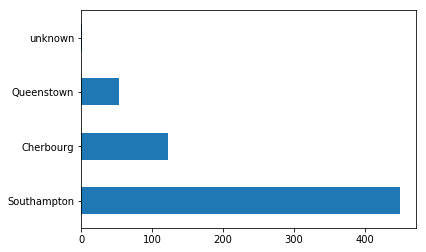

In [9]:
(dftrain['embark_town']
  .value_counts()
  .plot(kind='barh'))
plt.show()

女性は男性と比較して生存する可能性がかなり高かったようです。これはモデルが予測する特徴量から確認できるでしょう。


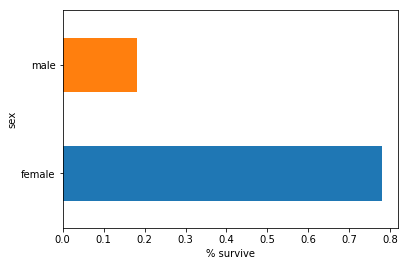

In [0]:
ax = (pd.concat([dftrain, y_train], axis=1)\
  .groupby('sex')
  .survived
  .mean()
  .plot(kind='barh'))
ax.set_xlabel('% survive')
plt.show()

## 特徴量とinput functionの作成

勾配ブースティングは特徴量として数値とカテゴリカル変数の両方を扱えます。
モデルで利用する特徴量を定義するために、feature column(訳注`tf.feature_column`のこと)を利用できます。feature columnはTensorFlowのestimatorと同時に利用できます。また、feature columnはone-hot-encoding, normalization, bucketizationのような特徴量エンジニアリングで用いられる機能を提供します。このチュートリアルでは`CATEGORICAL_COLUMNS`で定義したフィールドをカテゴリカル変数からone-hot-encoding([indicator column](https://www.tensorflow.org/api_docs/python/tf/feature_column/indicator_column))に変換して扱います :

In [0]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

def one_hot_cat_column(feature_name, vocab):
  return fc.indicator_column(
      fc.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # カテゴリカルな特徴量について、one-hot encodeが必要
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(fc.numeric_column(feature_name,
                                           dtype=tf.float32))

feature columnが変換した結果を確認できます。次の例では1行だけを`indicator_column`で変換した結果を出力しています。


In [12]:
example = dftrain.head(1)
class_fc = one_hot_cat_column('class', ('First', 'Second', 'Third'))
print('Feature value: "{}"'.format(example['class'].iloc[0]))
print('One-hot encoded: ', fc.input_layer(dict(example), [class_fc]).numpy())

Feature value: "Third"
One-hot encoded:  [[0. 0. 1.]]


また、全ての変換後の特徴量を一度に確認することもできます。

In [13]:
fc.input_layer(dict(example), feature_columns).numpy()

array([[22.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,
         7.25,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ]], dtype=float32)

次に、input functionを作成する必要があります。
これは作成するモデルが学習時・推論時に読み込むデータを指定するものです。
Pandasで扱っているデータを読み込ませて使う場合には、[`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) API の`from_tensor_slices`を利用できます。この方法はメモリ上に乗る比較的小さなデータセットに適するでしょう。大きなデータセットに対しては、
メモリ上に乗らないような場合であっても処理できるように、tf.data APIは([csv](https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset)を含む)様々なファイルフォーマットをサポートしています。

In [0]:
# 小さなデータセットなので、全体を一度に利用
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # 学習では、データセットを必要なだけ繰り返し (n_epochs=None).
    dataset = dataset.repeat(n_epochs)
    # メモリ上に乗る場合、バッチへの分割は不要
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn

# 学習用と評価用のinput functionを用意
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

## モデルの学習と評価

次のステップを順に実行します : 
1. モデルを初期化し、特徴量とハイパーパラメータを指定します
2. `train_input_fn`を用いて学習データをモデルに読み込ませ、`train`関数を用いてモデルを学習させます
3. 評価データ―― ここでは`dfeval` DataFrame――を用いてモデルのパフォーマンスを評価します。予測結果と配列`y_eval`とが一致しているかを確認します。

Below you will do the following steps:

1. Initialize the model, specifying the features and hyperparameters.
2. Feed the training data to the model using the `train_input_fn` and train the model using the `train` function.
3. You will assess model performance using the evaluation set—in this example, the `dfeval` DataFrame. You will verify that the predictions match the labels from the `y_eval` array.


勾配ブースティングモデルを用いる前に、線形識別器(ロジスティック回帰モデル)を用いて学習させてみましょう。まずシンプルなモデルをベンチマークとして学習させてみることは、ベストプラクティスです。

In [17]:
linear_est = tf.estimator.LinearClassifier(feature_columns)

# モデルの学習
linear_est.train(train_input_fn, max_steps=100)

# 評価
results = linear_est.evaluate(eval_input_fn)
print('Accuracy : ', results['accuracy'])
print('Dummy model: ', results['accuracy_baseline'])

Accuracy :  0.78409094
Dummy model:  0.625


次に勾配ブースティング木モデルを学習させてみましょう。
勾配ブースティングでは回帰 (`BoostedTreesRegressor`) と分類 (`BoostedTreesClassifier`) が、任意の2回微分可能なカスタム損失関数の利用(`BoostedTreesClassifier`) に加えてサポートされています。今回の目標はクラス――生存したかどうか――を予測することなので、`BoostedTreesClassifier`を使いましょう。


In [19]:
# データがメモリ内に収まるため、一つのレイヤーでデータセット全体を利用する。
# より高速になることが期待できる。
# データ全体を利用するためバッチ数を1とする。
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_batches_per_layer=n_batches)

# このモデルは学習ステップの実行数ではなく、指定した数の木が生成された段階で停止する。
est.train(train_input_fn, max_steps=100)

# 評価
results = est.evaluate(eval_input_fn)
print('Accuracy : ', results['accuracy'])
print('Dummy model: ', results['accuracy_baseline'])

Accuracy :  0.8181818
Dummy model:  0.625


パフォーマンス上の理由から、利用するデータがメモリ上に乗るときには、`boosted_trees_classifier_train_in_memory`の利用が推奨されます。一方、学習にかかる時間が問題にならない場合や、大規模なデータセットを利用した分散学習を行いたい場合には、上記のように`tf.estimator.BoostedTrees`を利用するのが良いでしょう。

このメソッド(訳注`boosted_trees_classifier_train_in_memory`)を利用した場合、データセット全体をメソッドで扱うために、入力データを分割すべきではありません。

In [0]:
def make_inmemory_train_input_fn(X, y):
  def input_fn():
    return dict(X), y
  return input_fn


train_input_fn = make_inmemory_train_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)
est = tf.contrib.estimator.boosted_trees_classifier_train_in_memory(
    train_input_fn,
    feature_columns)
print(est.evaluate(eval_input_fn)['accuracy'])


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

0.7916667


学習させたモデルを用いると、評価データ中の乗客について予測ができます。
Tensorflow のモデルはバッチやデータのコレクションを一度に予測するよう最適化されています。少し前で定義した`eval_input_fn`では評価データ全体を使うようにしています。

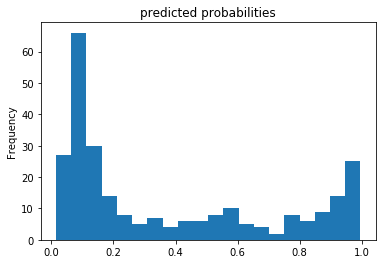

In [20]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')
plt.show()

最後に、結果のROC(receiver operating characteristic)を確認しましょう。これは真の陽性と偽陽性とのトレードオフについて、良い示唆を与えてくれます。

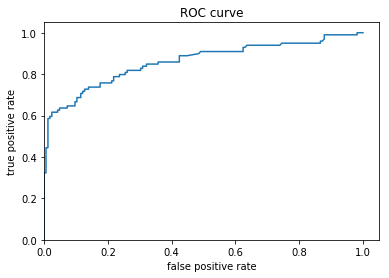

In [21]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()